In [1]:
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)

Tensorflow Version:  2.4.1


In [2]:
from saved_class_Decoder import Decoder
from saved_class_EncoderDecoder import EncoderDecoder
from saved_class_AdditiveAttention import AdditiveAttention
from saved_class_Seq2SeqEncoder import Seq2SeqEncoder

from saved_func_bleu import bleu
from saved_func_try_gpu import try_gpu
from saved_func_load_data_nmt import *
from saved_func_train_seq2seq import train_seq2seq
from saved_func_predict_seq2seq import predict_seq2seq
from saved_func_show_heatmaps import show_heatmaps

In [3]:
class AttentionDecoder(Decoder):
    """The base attention-based decoder interfae."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    @property
    def attention_weights(self):
        raise NotImplementedError

In [4]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(**kwargs)
        self.attention = AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                      return_sequences = True, return_state = True)
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # Shape of `outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`, `num_hiddens`)
        outputs, hidden_state = enc_outputs
        return (outputs, hidden_state, enc_valid_lens)
    
    def call(self, X, state, **kwargs):
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`, `num_hiddens`)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output `X`: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X) # Input `X` has shape: (`batch_size`, `num_steps`)
        X = tf.transpose(X, perm = (1, 0, 2))
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of `query`: (`batch_size`, 1, `num_hiddens`)
            query = tf.expand_dims(hidden_state[-1], axis = 1)
            # Shape of `context`: (`batch_size, 1, `num_hiddens`)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens, **kwargs)
            # Concatenate on the feature dimension
            x = tf.concat((context, tf.expand_dims(x, axis = 1)), axis = -1)
            out = self.rnn(x, hidden_state, **kwargs)
            hidden_state = out[1:]
            outputs.append(out[0])
            self._attention_weights.append(self.attention.attention_weights)
        # After fully-connected layer transformation, shape of `outputs`: (`batch_size`, `num_steps`, `vocab_size`)
        outputs = self.dense(tf.concat(outputs, axis = 1))
        return outputs, [enc_outputs, hidden_state, enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [5]:
encoder = Seq2SeqEncoder(vocab_size = 10, embed_size = 8, num_hiddens = 16, num_layers = 2)
decoder = Seq2SeqAttentionDecoder(vocab_size = 10, embed_size = 8, num_hiddens = 16, num_layers = 2)
X = tf.zeros((4,7))
state = decoder.init_state(encoder(X, training = False), None)
output, state = decoder(X, state, training = False)
print(output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape)

(4, 7, 10) 3 (4, 7, 16) 2 (4, 16)


## Training

loss 0.026, 786.8 tokens/sec on /GPU:0


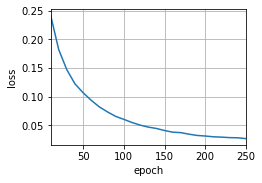

In [6]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [7]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, True)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(fra, translation, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => je me suis <unk> debout .,  bleu 0.000
he's calm . => il est malade .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [8]:
attention_weights = tf.reshape(tf.concat([step[0][0][0] for step in dec_attention_weight_seq], axis = 0), 
                               shape = (1, 1, -1, num_steps))

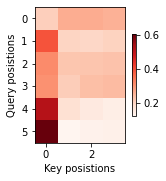

In [9]:
show_heatmaps(attention_weights[:, :, :, :len(engs[-1].split()) + 1],
              xlabel='Key posistions', ylabel='Query posistions')